# Extracting Validator Indicators

This section provides code for batch extraction of common psychological and behavioral indicators (validators) from the ABCD dataset, such as developmental delay, family conflict, number of friends, school connectedness, average grades, fluid/crystallized cognition, mental health services, medication history, etc.  
The workflow includes:

- Configuring the data root directory and data dictionary path
- Automatically locating the corresponding table files by variable names
- Supporting cross-table merging of related variables for each indicator
- Keeping only baseline visit (baseline_year_1_arm_1) data
- Outputting a CSV file for each indicator and merging them into a wide-format table

If variables are missing or paths are incorrect, the code will provide a prompt.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from validators import build_validators_baseline
from pathlib import Path
import pandas as pd
from functools import reduce
from scipy.linalg import orthogonal_procrustes
from utils import compute_autoencoder_loadings_with_plot

In [4]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import NMF
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from utils import translate_text
from sklearn.model_selection import KFold
import shap
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import optuna
from sklearn.model_selection import KFold
import torch.nn.functional as F
import io
from PIL import Image
from utils import get_cbcl_details
import random
import netron
from model_code import AE, VAE
import matplotlib.pyplot as plt
from IPython.display import Image
from validators import compare_efa_poly_vs_ae_poly


In [5]:
seed = 8  
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# # ======== 1│路径配置（按需修改） ========
# ROOT = Path(r"G:\ABCD\abcd-data-release-5.1")
# DICT = Path(r"G:\ABCD\datadict51.xlsx")

# VALIDATORS = {
#     "dev_delay"   : ["devhx_20_p", "devhx_21_p"],
#     "family_conf" : [f"fes_youth_q{i}" for i in range(1,10)],
#     "n_friends"   : ["resiliency5a_y","resiliency6a_y","resiliency5b_y","resiliency6b_y"],
#     "school_conn" : [f"school_{i}_y" for i in (2,3,4,5,6,7,8,9,10,12,15,17)],
#     "avg_grades"  : ["kbi_p_grades_in_school"],
#     "fluid_cog"   : ["nihtbx_fluidcomp_uncorrected"],
#     "cryst_cog"   : ["nihtbx_cryst_uncorrected"],
#     "mh_service"  : ["kbi_p_c_mh_sa"],
#     "med_history" : [f"medhx_2{c}" for c in "abcdefghijklmnopqrs"],
#     "brought_meds": ["brought_medications"],
# }

# # ======== 2│运行并输出 ========
# out_frames, wide = build_validators_baseline(
#     root=ROOT,
#     dict_path=DICT,
#     validators=VALIDATORS,
#     eventname="baseline_year_1_arm_1",
#     out_dir=Path("../output/validators"),            # 会输出各 tag 的 *_baseline.csv
#     dict_sheet=None,                      # 若 datadict 只有一个 sheet，可不用填
#     dict_engine="openpyxl",
#     verbose=True
# )

# # wide 就是 validators_baseline.csv 的 DataFrame 对象
# print(wide.shape, wide.columns[:10])


In [7]:
code_dir = Path(os.getcwd())
data_path = code_dir.parent / "data"
assert os.path.exists(
    data_path
), "Data directory not found. Make sure you're running this code from the root directory of the project."

with open(data_path / "cbcl_data_remove_low_frequency.csv", "r", encoding="utf-8") as f:
    qns = pd.read_csv(f)

X = qns.iloc[:, 1:].values

# Standardize the data
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and validation sets
X_train_raw, X_temp = train_test_split(X, test_size=0.2)
X_val_raw, X_test_raw = train_test_split(X_temp, test_size=0.5)


X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

items = [get_cbcl_details(col) for col in qns.iloc[:, 1:].columns]
items = np.array(items)

Early stopping at epoch 56


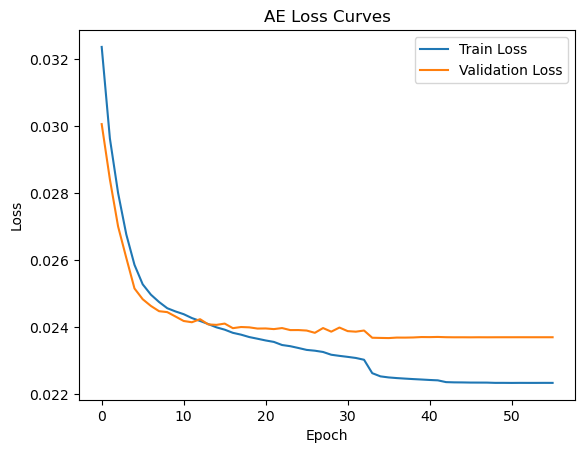

0.4009152302074923

In [8]:
autoencoder = AE(
    X_train, X_val,
    encoding_dim= 5,
    h1=112,
    h2=106,
    h3=96,
)
autoencoder.train(show_plot=True)

latent_factors, rec_errors, explained_variance_ratios, explained_variance_ratio_total, reconstructed = autoencoder.evaluate_on_data(X_test)
explained_variance_ratio_total


In [9]:
(
latent_factors,
reconstruction_errors,
explained_variance_ratios,
explained_variance_ratio_total,
reconstructed
        )= autoencoder.evaluate_on_data(X_scaled)
explained_variance_ratio_total

0.42180029601800845

In [10]:
# save latent_factors and read it
latent_factors = pd.DataFrame(latent_factors, columns=[f"factor_{i+1}" for i in range(latent_factors.shape[1])])
latent_factors.to_csv("../output/AE_scores.csv", index=False)
latent_factors = pd.read_csv("../output/AE_scores.csv")

In [11]:
# ① 取出字符串列
# ---------------------------------------------------
id_series = qns.iloc[:, 0]             
id_series.name = "src_subject_id"       

factor_cols = [f"factor_{i+1}" for i in range(latent_factors.shape[1])]
df_factors = pd.DataFrame(latent_factors, columns=factor_cols)

# ---------------------------------------------------
AE_scores = pd.concat([id_series.reset_index(drop=True),  # 防止索引不齐
                    df_factors.reset_index(drop=True)],
                   axis=1)

print(AE_scores.head())


     src_subject_id  factor_1  factor_2  factor_3  factor_4  factor_5
0  NDAR_INV003RTV85 -0.030016  0.043316 -0.053177 -0.273582  0.001013
1  NDAR_INV005V6D2C -0.058798  0.012767 -0.114772 -0.131957 -0.015826
2  NDAR_INV007W6H7B -0.032313 -0.026322  0.078937 -0.133209  0.055722
3  NDAR_INV00BD7VDC  0.053334 -0.027948  0.088233 -0.214067  0.027019
4  NDAR_INV00J52GPG -0.088370 -0.109517 -0.021262 -0.198964 -0.013064


In [12]:
from factor_analyzer import FactorAnalyzer
import pandas as pd

# 假设 qns 是你的 DataFrame，第一列是 src_subject_id，后面是 CBCL 条目
subject_id = qns.iloc[:, 0]
X = qns.iloc[:, 1:].values

# 标准化
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 跑 EFA (比如抽取 5 个因子)
fa = FactorAnalyzer(n_factors=5, rotation="geomin_obl")
fa.fit(X_scaled)

# 得到因子得分
efa_scores_np = fa.transform(X_scaled)   # shape: (N, n_factors)

# 拼成 DataFrame
efa_scores = pd.DataFrame(efa_scores_np, columns=[f"efa_{i+1}" for i in range(efa_scores_np.shape[1])])
efa_scores.insert(0, "src_subject_id", subject_id)

print(efa_scores.head())


     src_subject_id     efa_1     efa_2     efa_3     efa_4     efa_5
0  NDAR_INV003RTV85 -0.599865 -0.701899 -0.700889 -0.655698  0.314596
1  NDAR_INV005V6D2C -0.516217 -0.549871 -0.932015 -0.740218  0.037762
2  NDAR_INV007W6H7B -0.590526  0.110936  0.664026  1.489224  0.129497
3  NDAR_INV00BD7VDC -0.306076  0.399770  0.262685 -0.530880 -0.952974
4  NDAR_INV00J52GPG -0.309370 -0.674207  0.199109 -0.516779 -0.670295


In [13]:
import numpy as np
import pandas as pd
from scipy.linalg import orthogonal_procrustes

def procrustes_align_ae_to_efa(
    AE_scores: pd.DataFrame,
    efa_scores: pd.DataFrame,
    id_col: str = "src_subject_id",
    ae_cols: list | None = None,     # 例如 [c for c in AE_scores.columns if c.startswith("factor_")]
    efa_cols: list | None = None,     # 例如 [c for c in efa_scores.columns if c.startswith("efa_")]
    standardize: bool = True,         # 是否样本内标准化
    ddof: int = 1,                    # 用样本标准差（ddof=1）
    return_R: bool = True
):
    # 1) 自动识别列
    if ae_cols is None:
        ae_cols = [c for c in AE_scores.columns if c.startswith("factor_")]
    if efa_cols is None:
        efa_cols = [c for c in efa_scores.columns if c.startswith("efa_")]

    if len(ae_cols) == 0 or len(efa_cols) == 0:
        raise ValueError("未找到 AE 或 EFA 的因子列，请检查 ae_cols / efa_cols 选择规则。")

    # 保证列顺序稳定（可按自然序或你自定义的顺序）
    ae_cols = list(ae_cols)
    efa_cols = list(efa_cols)

    # 2) 以 id 做内连接并仅保留需用列
    left = AE_scores[[id_col] + ae_cols].copy()
    right = efa_scores[[id_col] + efa_cols].copy()
    common = pd.merge(left, right, on=id_col, how="inner", suffixes=("_AE", "_EFA"))

    # 3) 对双方列分别 dropna，确保对齐矩阵没有缺失
    #    先取 K（相同维度），再行内剔除缺失
    K = min(len(ae_cols), len(efa_cols))
    ae_use = ae_cols[:K]
    efa_use = efa_cols[:K]

    keep_mask = common[ae_use + efa_use].notna().all(axis=1)
    common = common.loc[keep_mask].reset_index(drop=True)

    if common.empty:
        raise ValueError("共同样本在所选因子列上均为缺失，无法对齐。")

    Z = common[ae_use].to_numpy(dtype=float)  # AE (n x K)
    F = common[efa_use].to_numpy(dtype=float) # EFA(n x K)

    # 4) 样本内中心化/标准化（推荐）
    if standardize:
        Z_mean = Z.mean(axis=0, keepdims=True)
        F_mean = F.mean(axis=0, keepdims=True)
        Z_std  = Z.std(axis=0, ddof=ddof, keepdims=True)
        F_std  = F.std(axis=0, ddof=ddof, keepdims=True)

        # 防止除以 0
        Z_std[Z_std == 0] = 1.0
        F_std[F_std == 0] = 1.0

        Zs = (Z - Z_mean) / Z_std
        Fs = (F - F_mean) / F_std
    else:
        # 只做均值中心化更稳（Procrustes 对平移不不变）
        Zs = Z - Z.mean(axis=0, keepdims=True)
        Fs = F - F.mean(axis=0, keepdims=True)

    # 5) 正交 Procrustes（把 AE 旋转到 EFA）
    R, scale = orthogonal_procrustes(Zs, Fs)  # Zs @ R ≈ Fs

    Z_aligned = Zs @ R

    # 6) 是否需要反标准化？
    #    通常下游比较/回归用标准化空间更稳，这里就保持标准化空间。
    #    如果你想让对齐后的 AE 用 EFA 的量纲，可取消下面两行注释：
    # Z_aligned = Z_aligned * F_std + F_mean

    # 7) 把对齐结果写回 AE_scores 的相同行列（列名保持 AE 的列名不变）
    AE_aligned = AE_scores.copy()
    # 和 common 对应的 id 行索引
    idx_map = AE_aligned.set_index(id_col).index.get_indexer(common[id_col])
    # 更直接：用 loc 依据 id 对齐写回
    AE_aligned.loc[
        AE_aligned[id_col].isin(common[id_col]), ae_use
    ] = Z_aligned

    out = {"AE_aligned": AE_aligned, "common_ids": common[id_col].tolist()}
    if return_R:
        out["R"] = R
        out["scale"] = scale
    return out
# 假设：
# AE_scores: 包含 src_subject_id 与 AE 因子列（如 factor_1...）
# efa_scores: 包含 src_subject_id 与 EFA 因子列（如 efa_1...）

res = procrustes_align_ae_to_efa(
    AE_scores=AE_scores,
    efa_scores=efa_scores,
    id_col="src_subject_id",
    ae_cols=[c for c in AE_scores.columns if c.startswith("factor_")],  # 你实际的 AE 因子列规则
    efa_cols=[c for c in efa_scores.columns if c.startswith("efa_")],    # 你实际的 EFA 因子列规则
    standardize=True,   # 样本内放缩（ddof=1）
    ddof=1,
    return_R=True
)

AE_scores_aligned = res["AE_aligned"]   # 这是对齐后可直接替换使用的 AE_scores
R = res["R"]                            # 需要的话可保存旋转矩阵


In [14]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# 假设 qns 是你的 DataFrame，第一列是 src_subject_id，后面是 CBCL 条目
subject_id = qns.iloc[:, 0]
X = qns.iloc[:, 1:].values

# 标准化 (NMF 要求非负输入，这里 MinMaxScaler 很合适)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 跑 NMF (比如抽取 5 个因子)
nmf = NMF(n_components=5, init="nndsvda", random_state=0, max_iter=1000)
nmf_scores_np = nmf.fit_transform(X_scaled)   # shape: (N, n_factors)

# 拼成 DataFrame（名字保持一致）
NMF_scores = pd.DataFrame(nmf_scores_np, columns=[f"factor_{i+1}" for i in range(nmf_scores_np.shape[1])])
NMF_scores.insert(0, "src_subject_id", subject_id)

print(NMF_scores.head())


     src_subject_id  factor_1  factor_2  factor_3  factor_4  factor_5
0  NDAR_INV003RTV85  0.000000  0.007864  0.000569  0.034510  0.002419
1  NDAR_INV005V6D2C  0.000000  0.019990  0.000000  0.000000  0.000000
2  NDAR_INV007W6H7B  0.009373  0.031146  0.073482  0.115465  0.162886
3  NDAR_INV00BD7VDC  0.038503  0.067724  0.067584  0.084619  0.003101
4  NDAR_INV00J52GPG  0.033625  0.000000  0.003983  0.090890  0.026211


func 同样本、分块累加ΔR²/Nagelkerke R²、导出两侧结果表与汇总表、生成网格子图

In [ ]:
result = compare_efa_poly_vs_ae_poly(
    factors_scores=AE_scores,       # AE DataFrame
    efa_scores=efa_scores,               # EFA DataFrame
    validators_csv="../output/validators/validators_baseline.csv",
    model_label_ae = "AE",
    model_label_efa = "EFA",
    save_dir="../output/efa_vs_NMF_AE_plots_poly_compare",
    ae_poly_degree=4,
    efa_poly_degree=4,

)

# 直接显示结果图
Image(filename=result["paths"]["grid_png"])



In [17]:
result = compare_efa_poly_vs_ae_poly(
    factors_scores=AE_scores,
    efa_scores=efa_scores,
    validators_csv="../output/validators/validators_baseline.csv",
    model_label_ae = "AE",
    model_label_efa = "EFA",
    save_dir="../output/efa_vs_NMF_AE_plots_poly_compare",

    # 关键开关
    strict_common_sample=True,             # 统一样本，公平
    rotation_invariant_full_poly=True,     # 旋转不敏感
    ae_poly_degree=4,
    efa_poly_degree=4,                     # 两边相同次数，公平
    include_interactions=False,            # 已由“完整多项式”覆盖
    oos_cv_folds=5,                        # 样本外
    use_probit_for_binary=True,
    binary_r2_metric="tjur",
    compare_bootstrap_B=10,               # 稳定比较
)


G:\ABCD\script\trail\utils\validators.py:1106: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ref[col] = Z[:, j]
G:\ABCD\script\trail\utils\validators.py:1106: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ref[col] = Z[:, j]
G:\ABCD\script\trail\utils\validators.py:1106: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfr

         outcome  block model  total_R2  p_value_compare
0     avg_grades      1    AE  0.014783              NaN
1     avg_grades      2    AE  0.020720              NaN
2     avg_grades      3    AE  0.081546              NaN
3     avg_grades      4    AE  0.177873              NaN
4     avg_grades      5    AE  0.190262              NaN
5   brought_meds      1    AE  0.001729              NaN
6   brought_meds      2    AE  0.004823              NaN
7   brought_meds      3    AE  0.046263              NaN
8   brought_meds      4    AE  0.059880              NaN
9   brought_meds      5    AE  0.070082              NaN
10     cryst_cog      1    AE  0.003521              NaN
11     cryst_cog      2    AE  0.011234              NaN
12     cryst_cog      3    AE  0.026005              NaN
13     cryst_cog      4    AE  0.064818              NaN
14     cryst_cog      5    AE  0.081836              NaN
15     dev_delay      1    AE  0.001698              NaN
16     dev_delay      2    AE  

[autoreload of validators failed: Traceback (most recent call last):
  File "c:\Anaconda\envs\mne\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "c:\Anaconda\envs\mne\Lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "c:\Anaconda\envs\mne\Lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "G:\ABCD\script\trail\utils\validators.py", line 1, in <module>
    from curses import panel
  File "c:\Anaconda\envs\mne\Lib\curses\__init__.py", line 13, in <module>
    from _curses import *
ModuleNotFoundError: No module named '_curses'
]
c:\Anaconda\envs\mne\Lib\site-packages\statsmode

         outcome  block model  total_R2  p_value_compare
0     avg_grades      1    AE  0.014783              NaN
1     avg_grades      2    AE  0.019671              NaN
2     avg_grades      3    AE  0.077093              NaN
3     avg_grades      4    AE  0.164731              NaN
4     avg_grades      5    AE  0.168033              NaN
5   brought_meds      1    AE  0.001729              NaN
6   brought_meds      2    AE  0.002922              NaN
7   brought_meds      3    AE  0.041382              NaN
8   brought_meds      4    AE  0.045176              NaN
9   brought_meds      5    AE  0.045678              NaN
10     cryst_cog      1    AE  0.003521              NaN
11     cryst_cog      2    AE  0.009075              NaN
12     cryst_cog      3    AE  0.019014              NaN
13     cryst_cog      4    AE  0.053007              NaN
14     cryst_cog      5    AE  0.054746              NaN
15     dev_delay      1    AE  0.001698              NaN
16     dev_delay      2    AE  

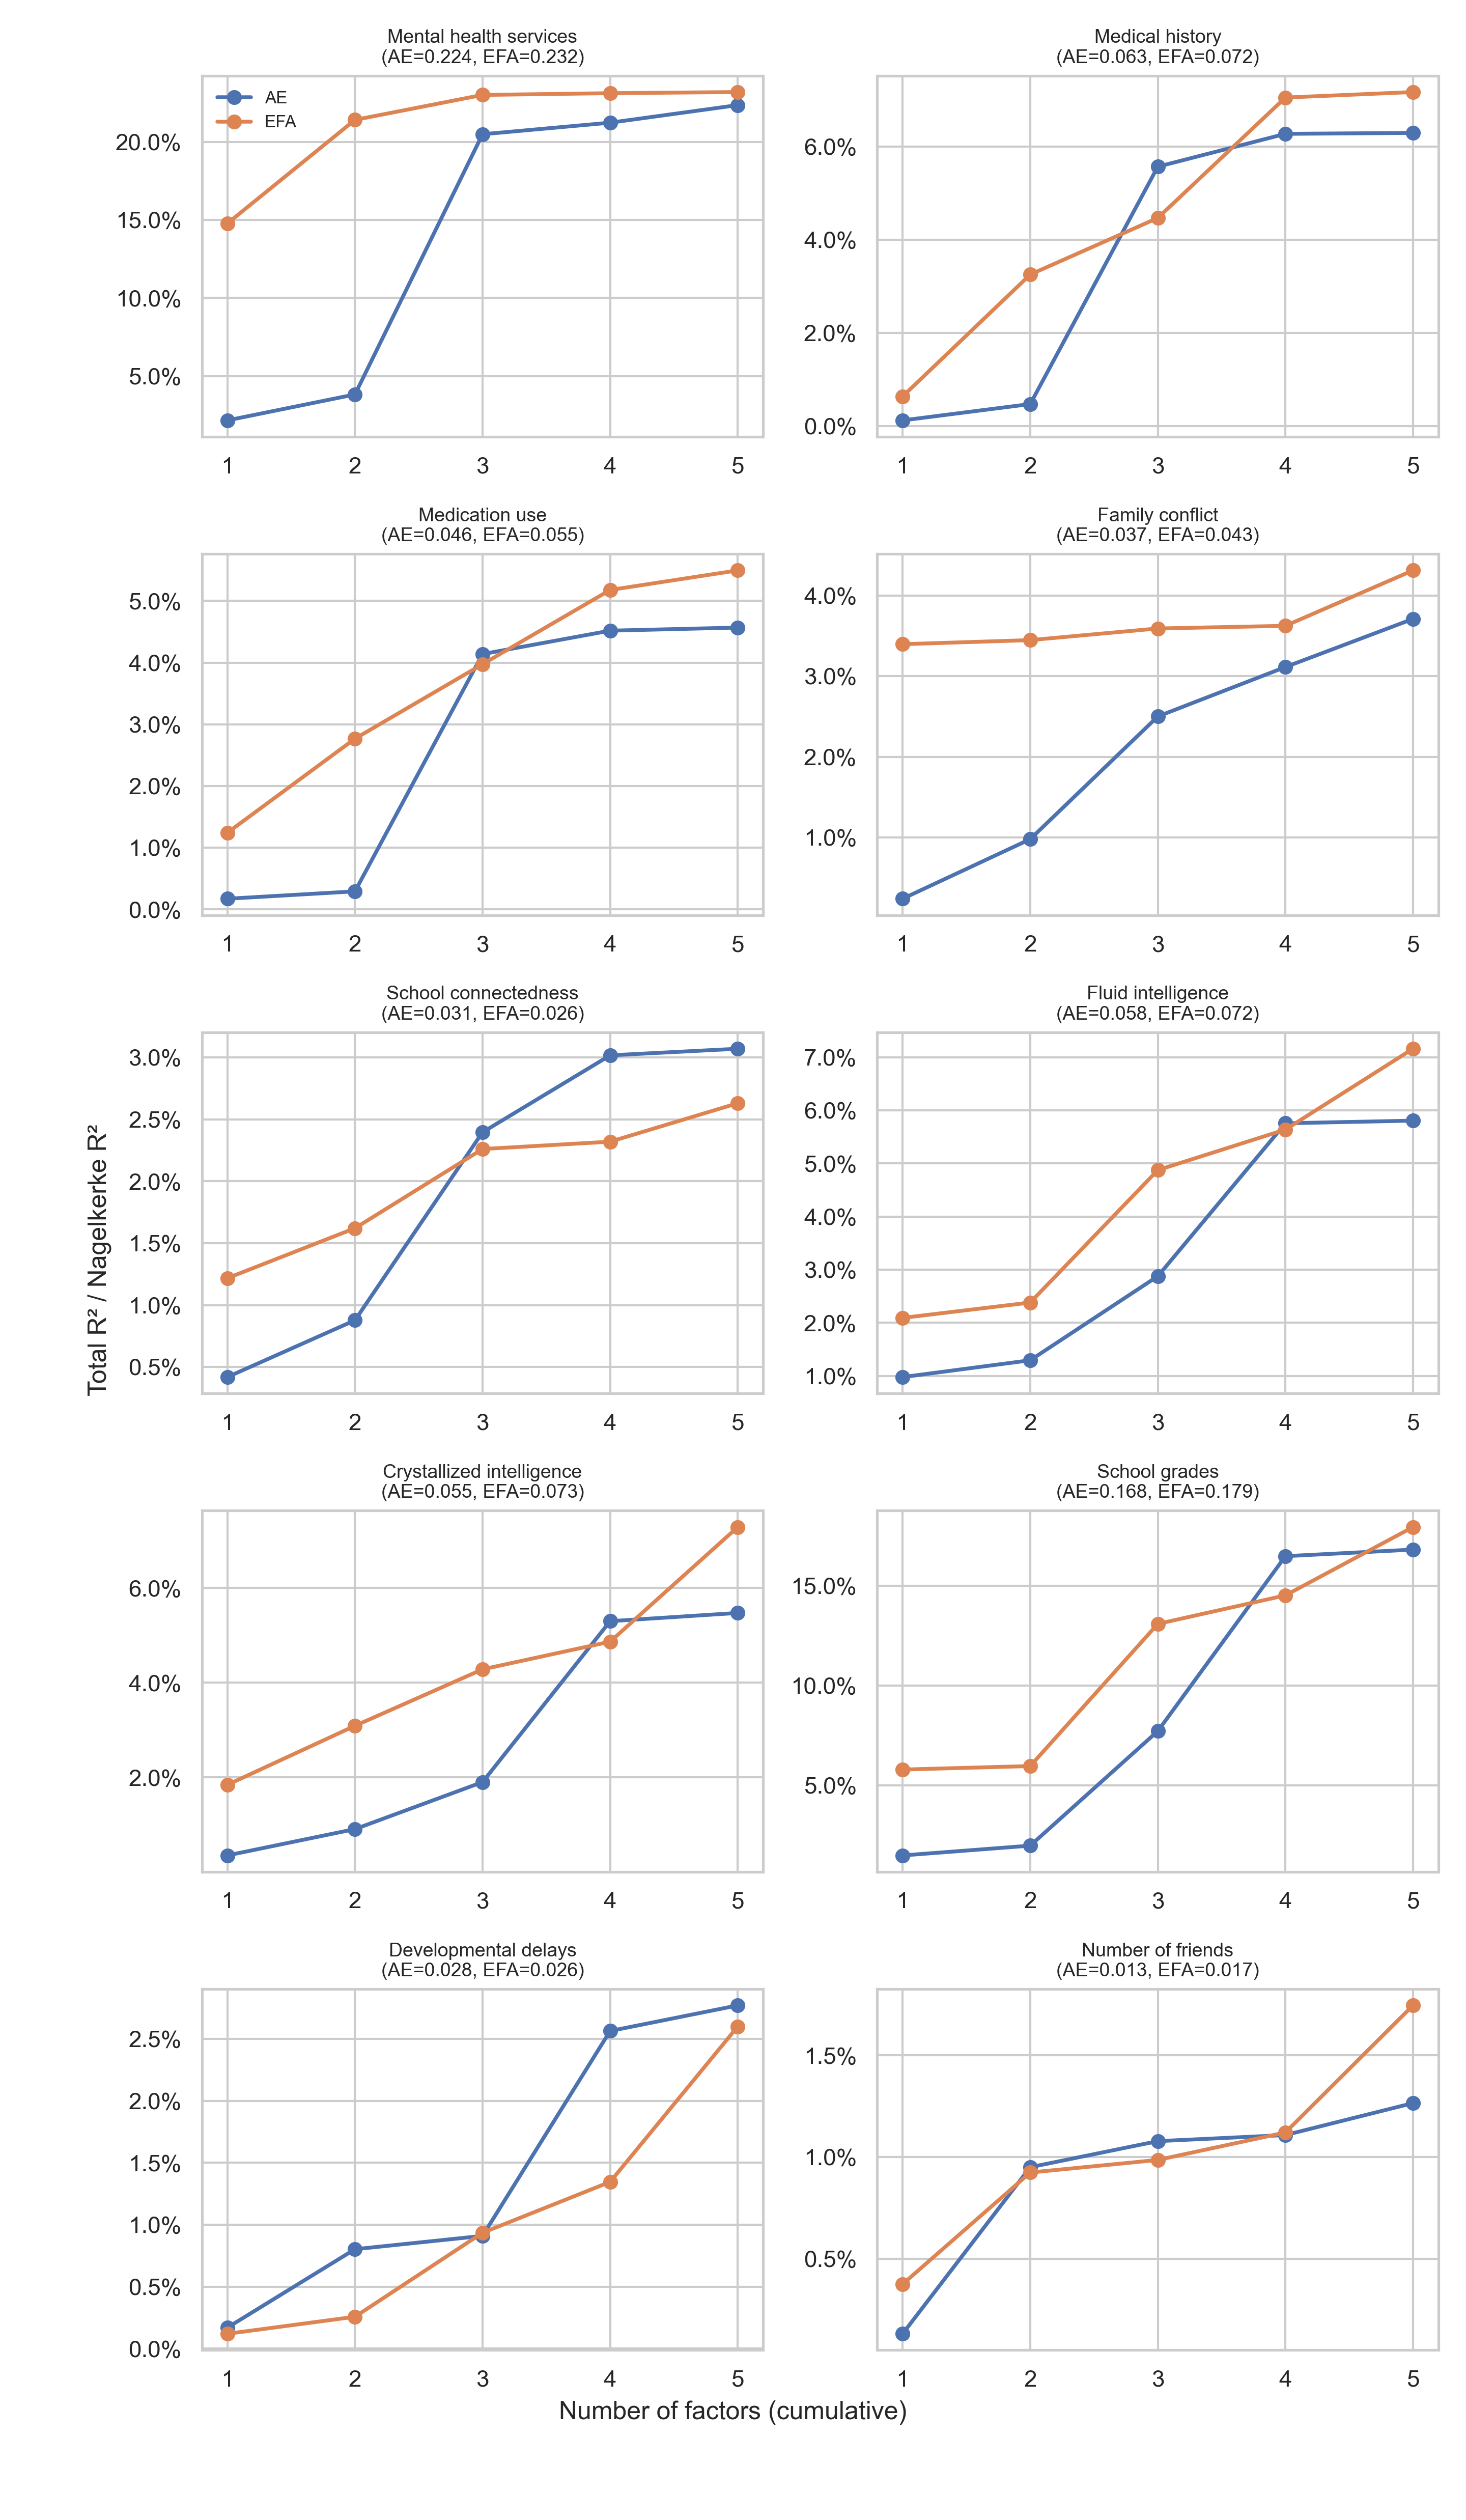

In [41]:
result = compare_efa_poly_vs_ae_poly(
    factors_scores=AE_scores,       # AE DataFrame
    efa_scores=efa_scores,               # EFA DataFrame
    validators_csv="../output/validators/validators_baseline.csv",
    model_label_ae = "AE",
    model_label_efa = "EFA",
    save_dir="../output/efa_vs_NMF_AE_plots_poly_compare0",
    ae_poly_degree=4,
    efa_poly_degree=4,
    compare_bootstrap_B =0,
)

# 直接显示结果图
Image(filename=result["paths"]["grid_png"])

c:\Anaconda\envs\mne\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The probit link alias is deprecated. Use Probit instead. The probit link alias will be removed after the 0.15.0 release.
  warnings.warn(
c:\Anaconda\envs\mne\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The probit link alias is deprecated. Use Probit instead. The probit link alias will be removed after the 0.15.0 release.
  warnings.warn(
c:\Anaconda\envs\mne\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The probit link alias is deprecated. Use Probit instead. The probit link alias will be removed after the 0.15.0 release.
  warnings.warn(
c:\Anaconda\envs\mne\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The probit link alias is deprecated. Use Probit instead. The probit link alias will be removed after the 0.15.0 release.
  warnings.warn(
c:\Anaconda\envs\mne\Lib\site-packages\statsmodels\genmod\families\l

         outcome  block model  total_R2  p_value_compare
0     avg_grades      1    AE  0.017919              NaN
1     avg_grades      2    AE  0.032507              NaN
2     avg_grades      3    AE  0.124211              NaN
3     avg_grades      4    AE  0.153204              NaN
4     avg_grades      5    AE  0.154109              NaN
5   brought_meds      1    AE  0.004965              NaN
6   brought_meds      2    AE  0.007716              NaN
7   brought_meds      3    AE  0.041723              NaN
8   brought_meds      4    AE  0.046285              NaN
9   brought_meds      5    AE  0.046341              NaN
10     cryst_cog      1    AE  0.010170              NaN
11     cryst_cog      2    AE  0.030216              NaN
12     cryst_cog      3    AE  0.040651              NaN
13     cryst_cog      4    AE  0.054803              NaN
14     cryst_cog      5    AE  0.055318              NaN
15     dev_delay      1    AE  0.006441              NaN
16     dev_delay      2    AE  

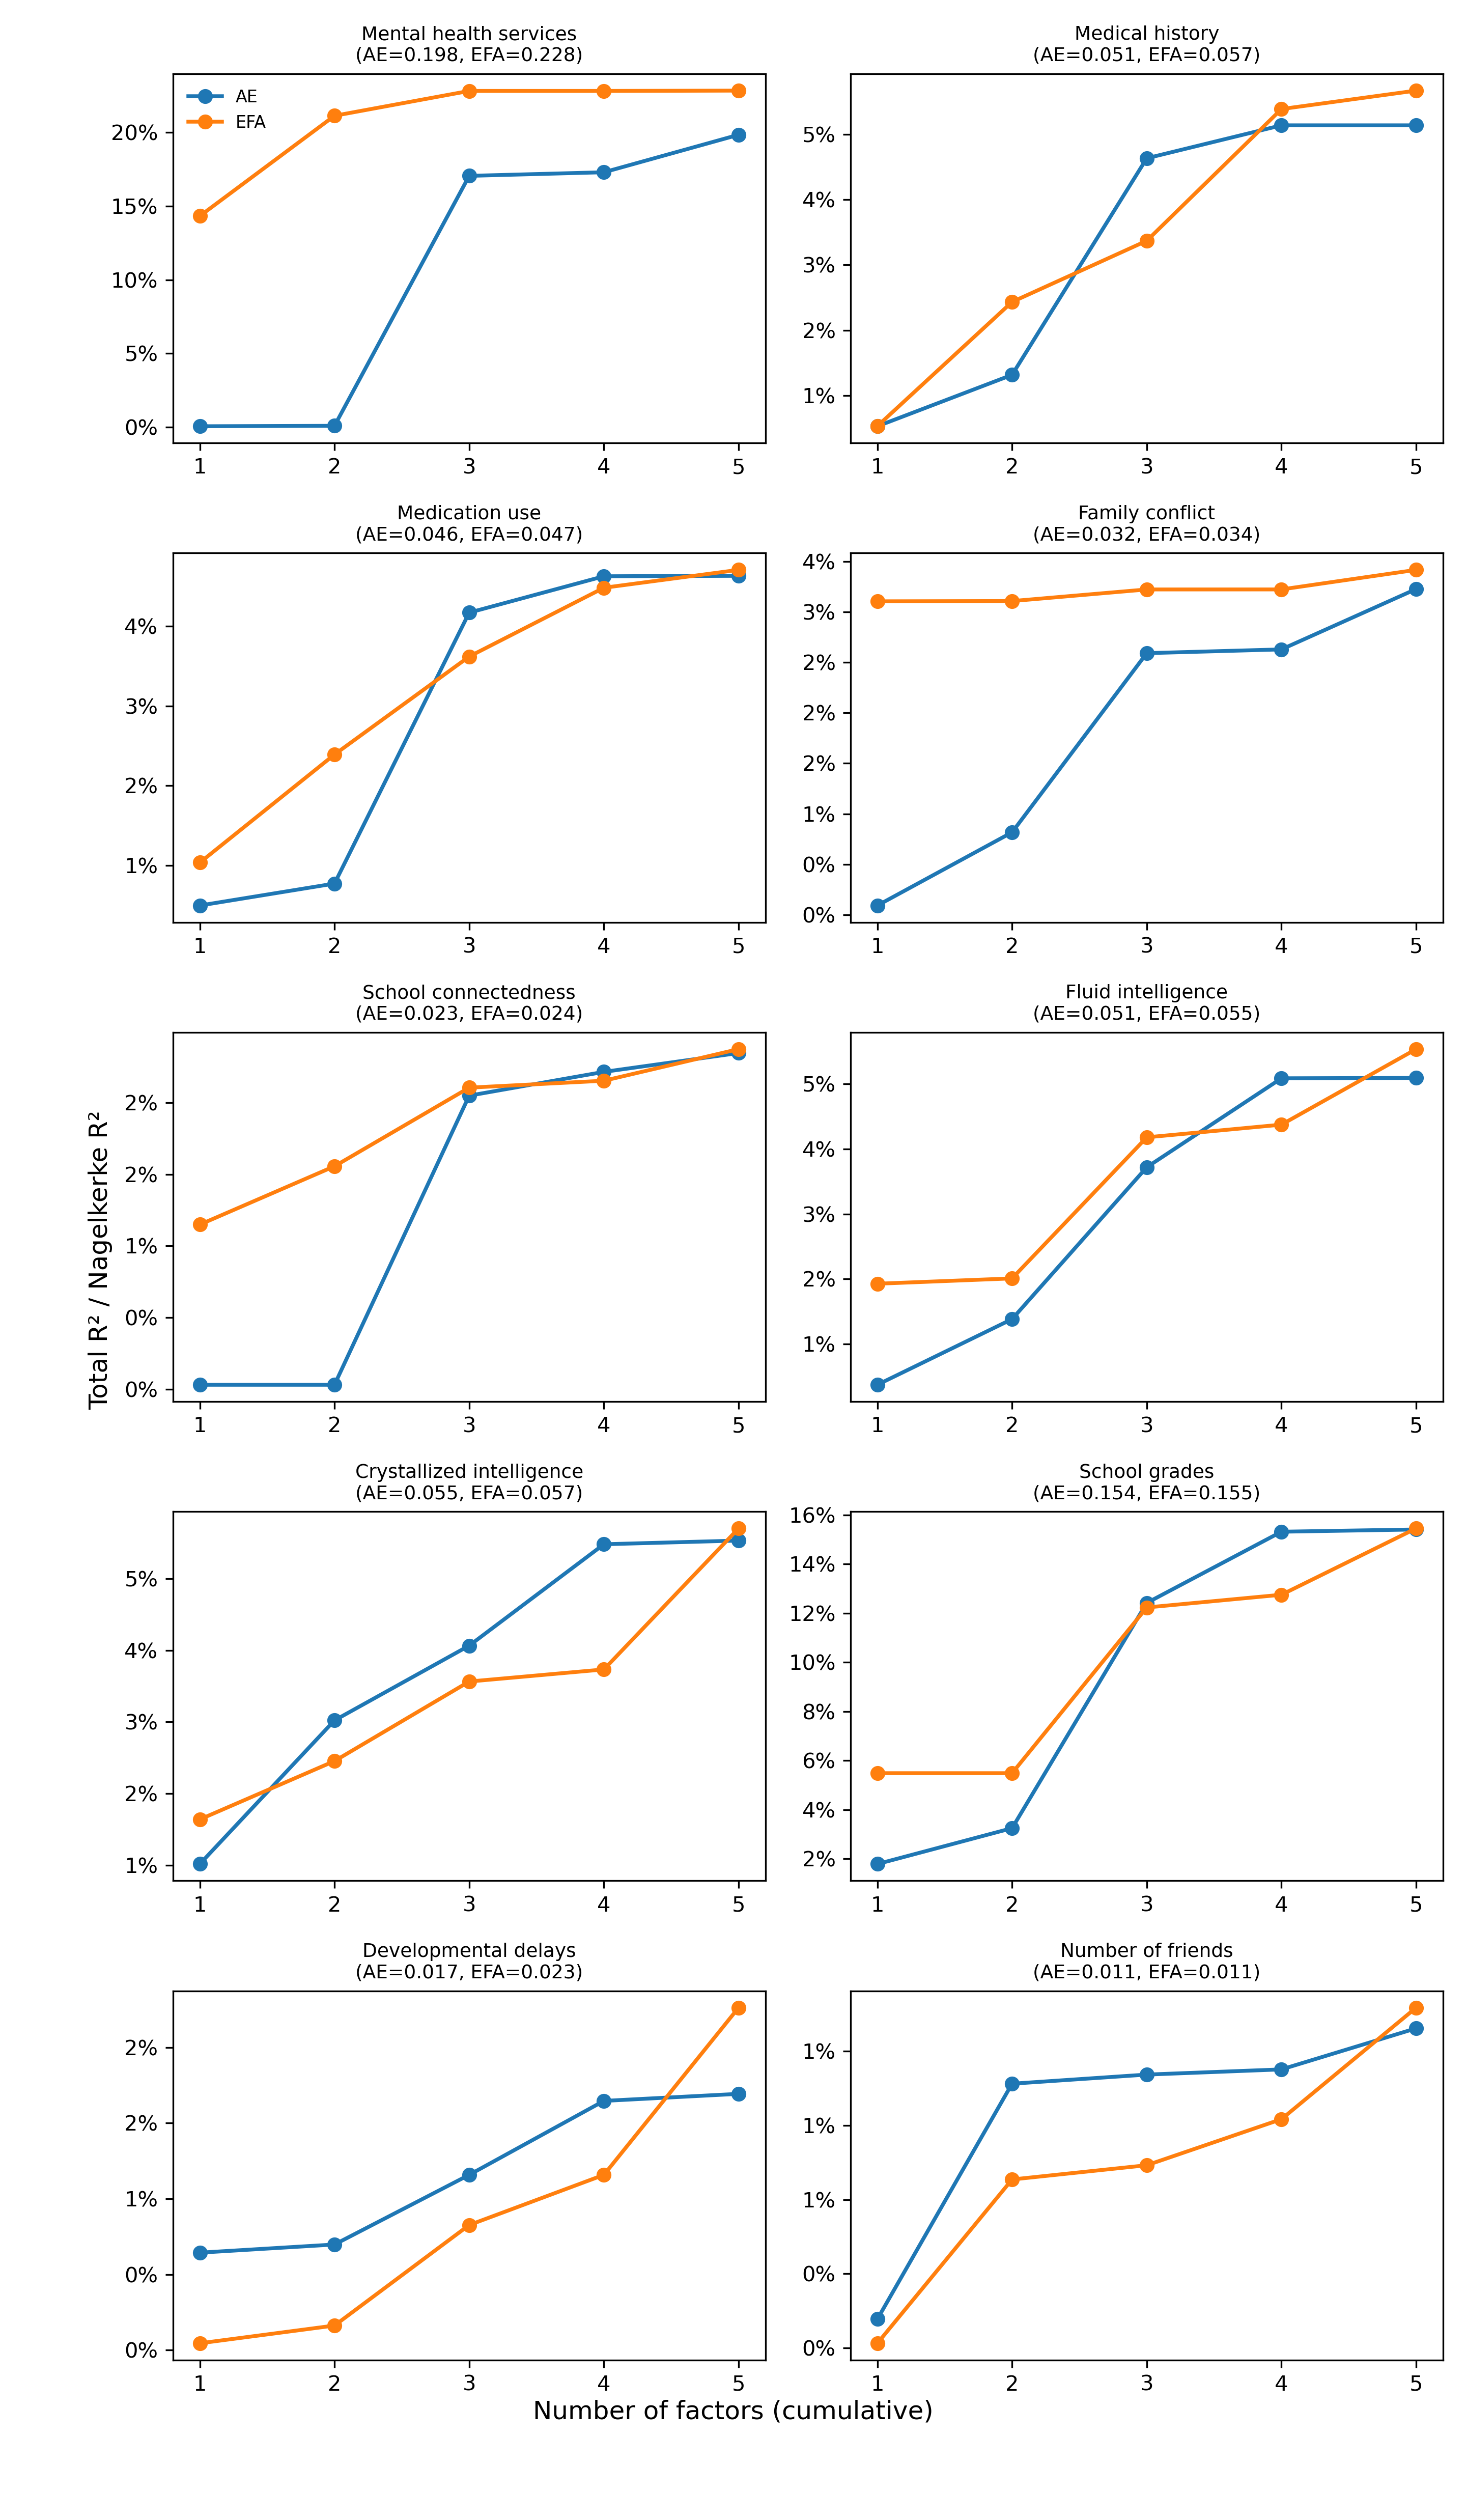

In [50]:
result = compare_efa_poly_vs_ae_poly(
    factors_scores=AE_scores,
    efa_scores=efa_scores,
    validators_csv="../output/validators/validators_baseline.csv",
    model_label_ae="AE",
    model_label_efa="EFA",
    save_dir="../output/test",

    ae_poly_degree=1,
    efa_poly_degree=1,
    include_interactions=False,
    compare_bootstrap_B=0,

    strict_common_sample=False,
    use_ddof1_zscore=True,
    use_probit_for_binary=True,      # probit
    allow_logit_ridge_fallback=False,
    binary_r2_metric="mplus_latent"  # ★ Mplus 风格 R²
)

from IPython.display import Image
Image(filename=result["paths"]["grid_png"])


Empty DataFrame
Columns: [outcome, block, model, total_R2, p_value_compare]
Index: []


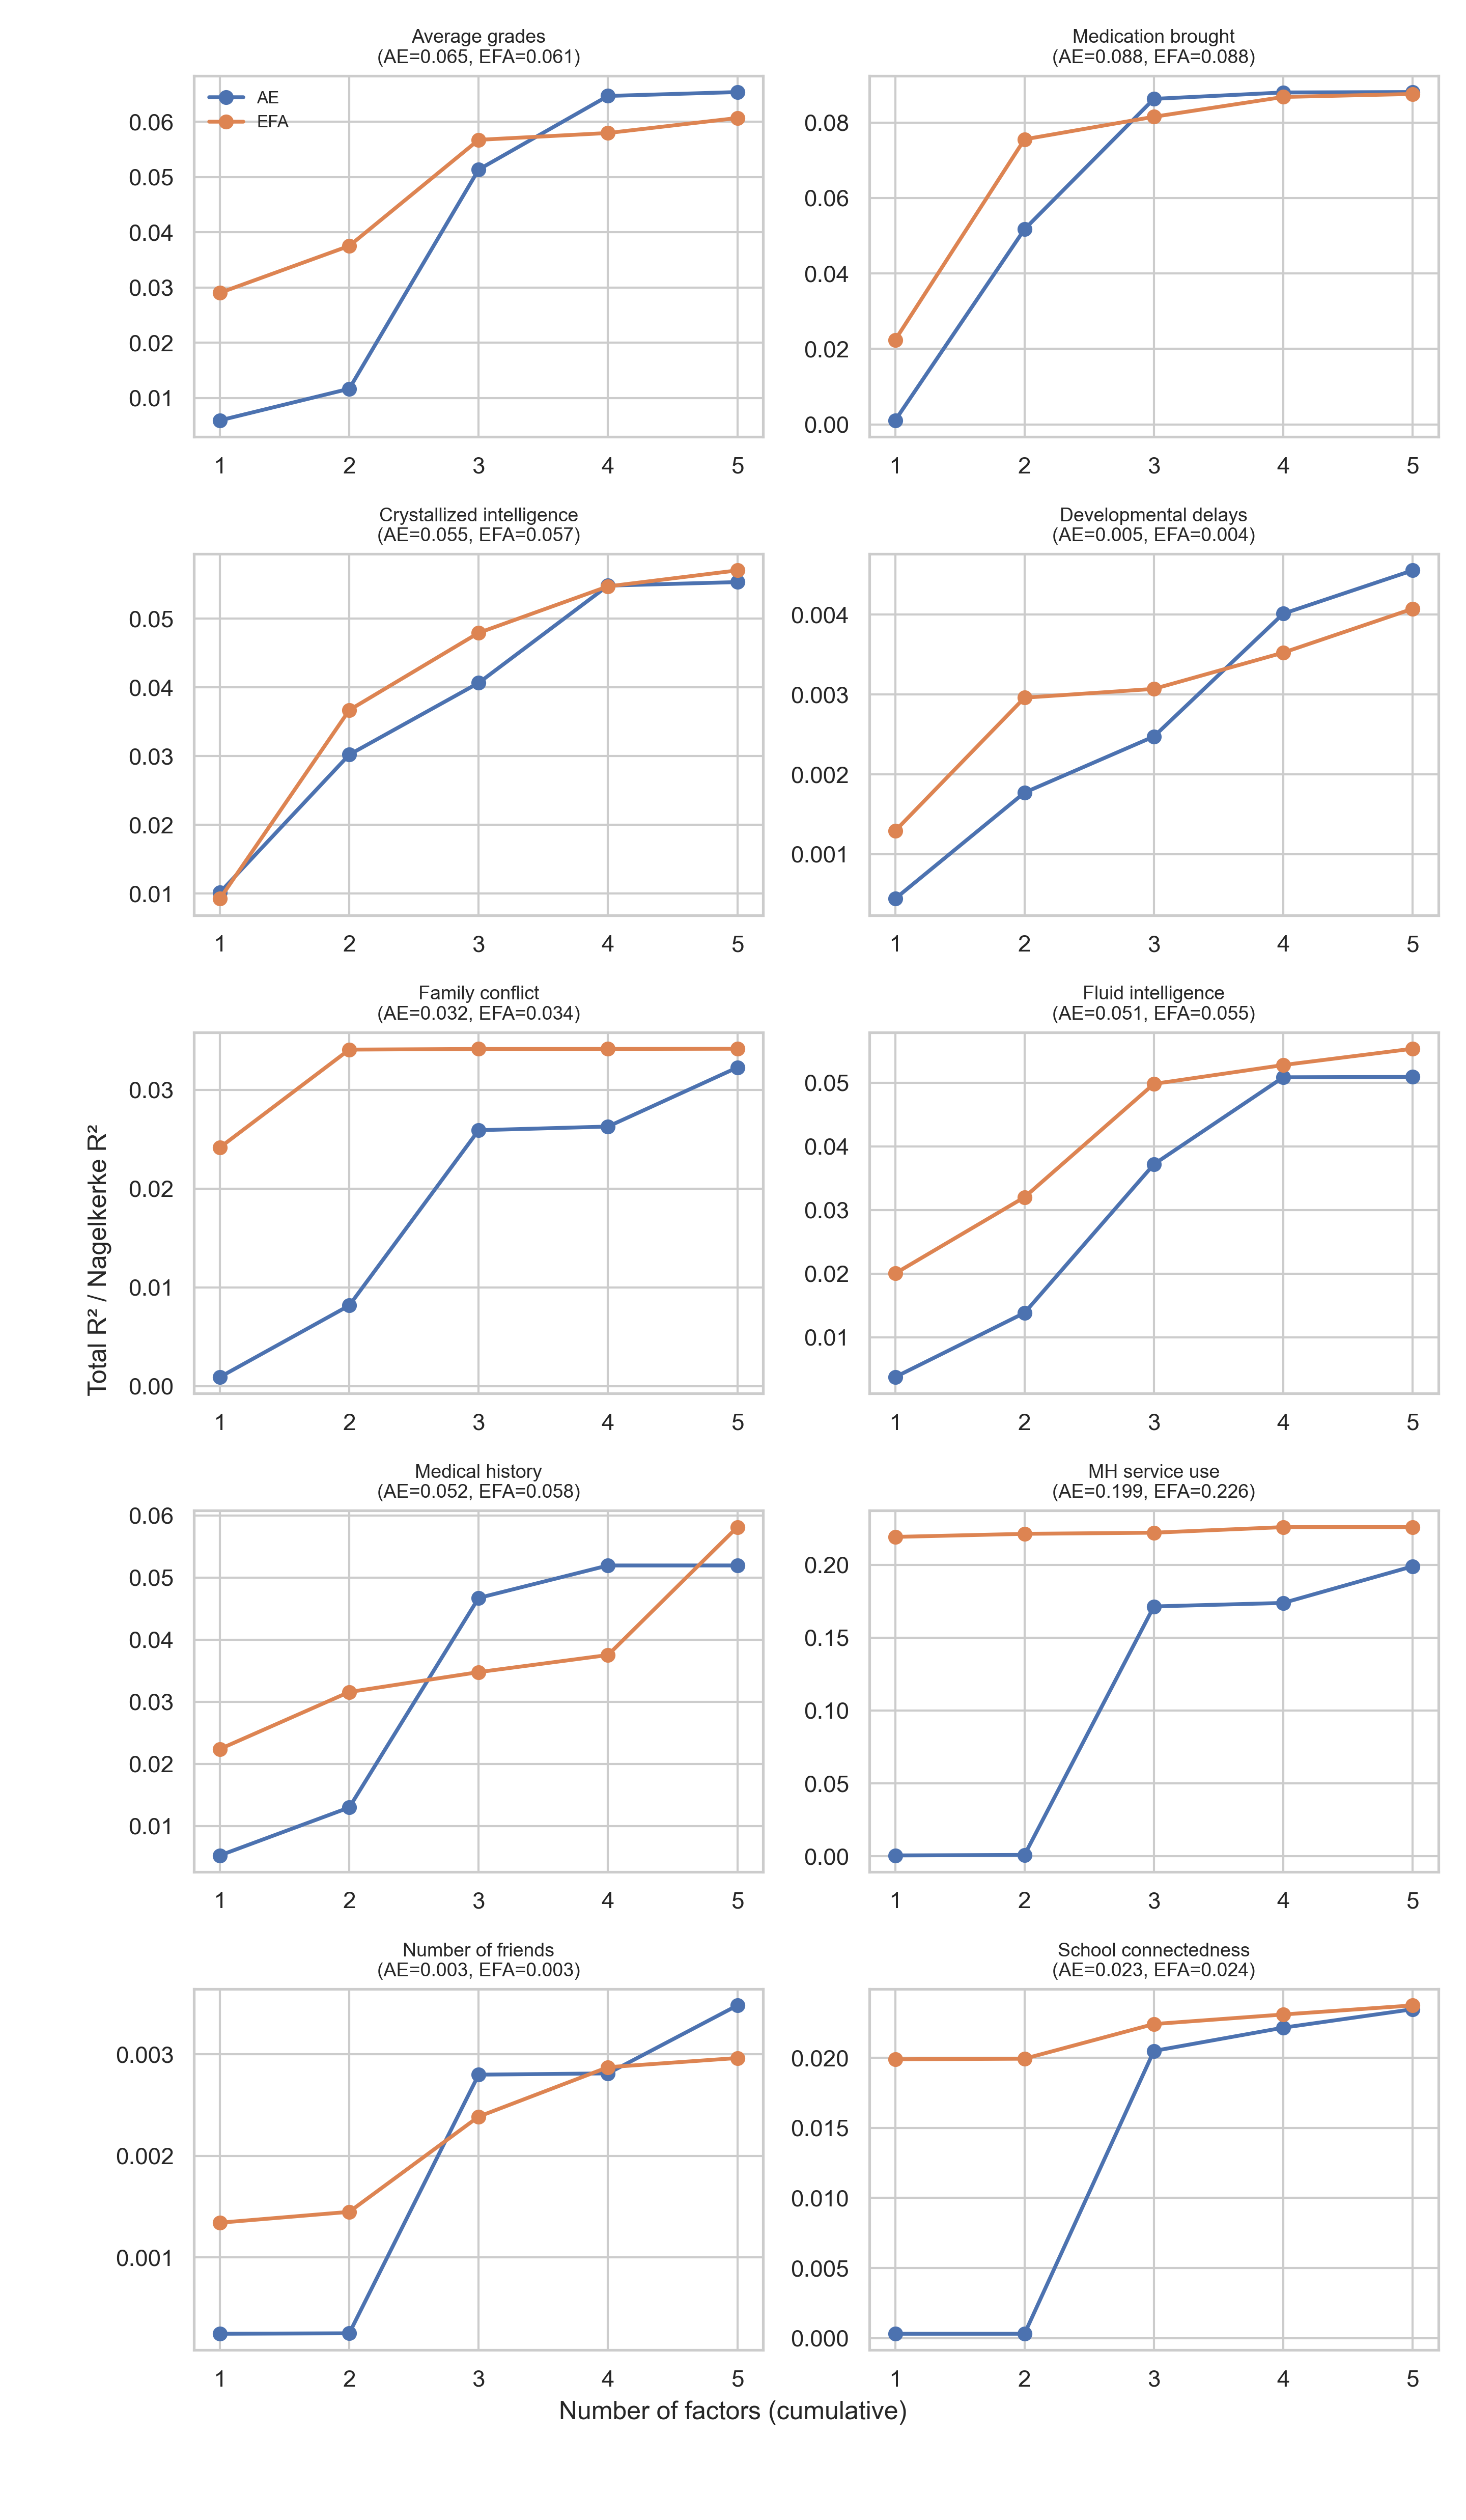

In [65]:
result = compare_efa_poly_vs_ae_poly(
    factors_scores=AE_scores,       # AE DataFrame
    efa_scores=efa_scores,               # EFA DataFrame
    validators_csv="../output/validators/validators_baseline.csv",
    model_label_ae = "AE",
    model_label_efa = "EFA",
    save_dir="../output/test",
    ae_poly_degree=1,
    efa_poly_degree=1,
    compare_bootstrap_B =10

)

# 直接显示结果图
Image(filename=result["paths"]["grid_png"])



In [20]:
AE_scores_aligned.iloc[:, 1:]

,factor_1,factor_2,factor_3,factor_4,factor_5
0,-0.692685,-1.112337,-0.185745,-0.545492,0.799837
1,-0.813630,-0.221007,-1.303738,-0.684626,-0.525735
2,-2.171187,-1.087373,1.831569,1.712822,-0.694181
3,0.886820,-0.373139,0.116794,0.603688,0.143088
4,0.537911,-0.949101,0.383935,-0.493566,-1.572315
...,...,...,...,...,...
9794,0.613729,2.506852,0.766166,0.338624,-2.144677
9795,-0.366601,-0.441008,-0.795545,-0.375779,-0.370849
9796,0.377988,1.057041,-1.357633,-0.259970,-0.408759
9797,0.313338,-0.877918,-0.320260,0.373703,1.339977


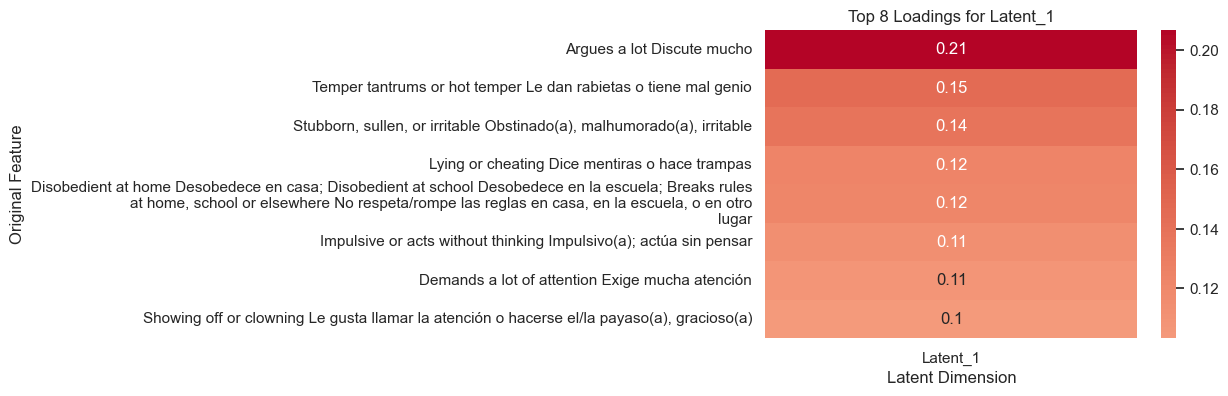

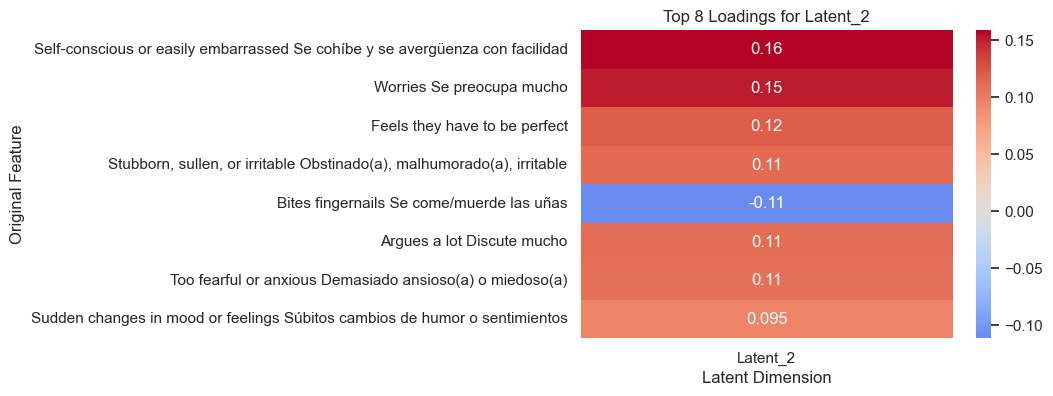

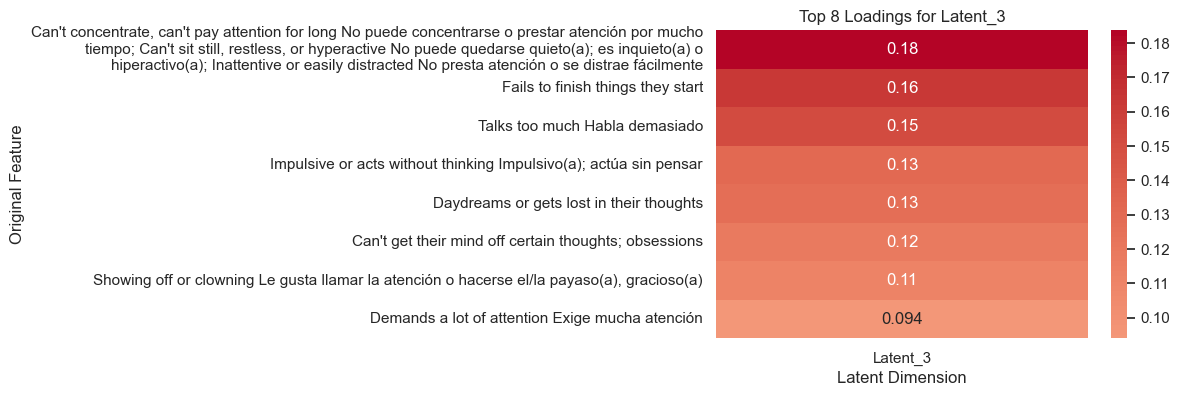

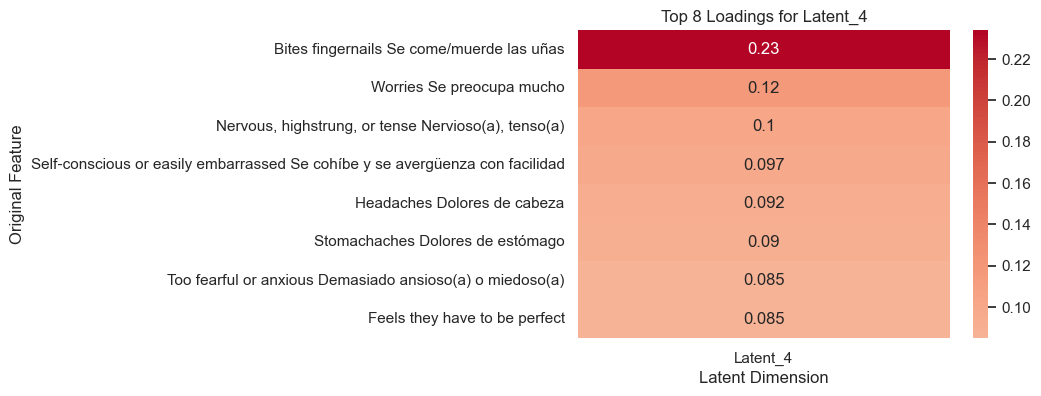

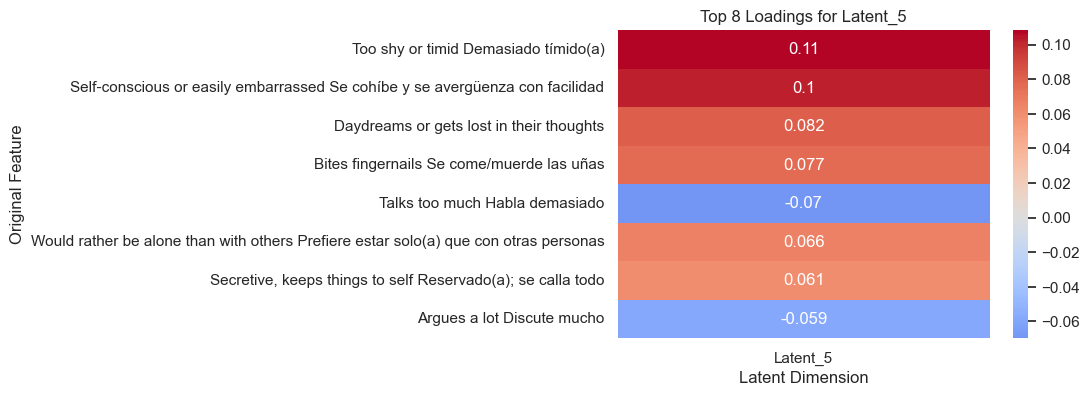

,Latent_1,Latent_2,Latent_3,Latent_4,Latent_5
Acts too young for their age,0.053177,0.039490,0.086881,0.004887,0.044388
Argues a lot Discute mucho,0.206698,0.111225,0.061388,0.046993,-0.058502
Fails to finish things they start,0.085604,0.061255,0.162434,0.033639,0.057989
There is very little they enjoy,0.036353,0.037530,0.021648,0.014692,0.031187
Bowel movements outside toilet Hace sus necesidades en la ropa o en lugares inadecuados,0.004928,0.003450,0.005600,0.002854,0.004019
...,...,...,...,...,...
"Disobedient at home Desobedece en casa; Disobedient at school Desobedece en la escuela; Breaks rules at home, school or elsewhere No respeta/rompe las reglas en casa, en la escuela, o en otro\n lugar",0.121805,0.030649,0.071271,0.012778,0.012287
Doesn't get along with other kids No se lleva bien con otros niños(as)/jóvenes; Not liked by other kids No le cae bien a otros niños(as)/jóvenes,0.049201,0.031009,0.040247,0.012383,0.029267
Hears sound or voices that aren't there Oye sonidos o voces que no existen; Sees things that aren't there Ve cosas que no existen,0.003254,0.004978,0.006775,0.002943,0.003975
Overeating Come demasiado; Overweight Tiene sobrepeso,0.024414,0.026993,0.024812,0.021176,0.014384


In [21]:
compute_autoencoder_loadings_with_plot(AE_scores_aligned.iloc[:, 1:], X_scaled, items, top_k=8)